In [1]:
!uv pip install -q --system numba-cuda==0.4.0

In [2]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

# Black and white

Now that we've had a look at multi-dimensional indexing, why don't you try and use two-dimensional indexing to make our image black and white?

Instead of operating over all pixels channel by channel we want to just operate over all pixels and average the channels out.

Before you begin, please turn off Google Colab's autocompletion by going to the settings gear in the top right -> Editor -> Uncheck "Automatically trigger code completions".

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import cuda
import numpy as np
import math

plt.rcParams["figure.figsize"] = (30, 4)

**1. Load our image with matplotlib.**

--2025-02-17 23:56:49--  https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/main/gpu-python-tutorial/images/numba.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3809 (3.7K) [image/png]
Saving to: ‘numba.png.2’

numba.png.2         100%[===================>]   3.72K  --.-KB/s    in 0s      

2025-02-17 23:56:49 (58.9 MB/s) - ‘numba.png.2’ saved [3809/3809]



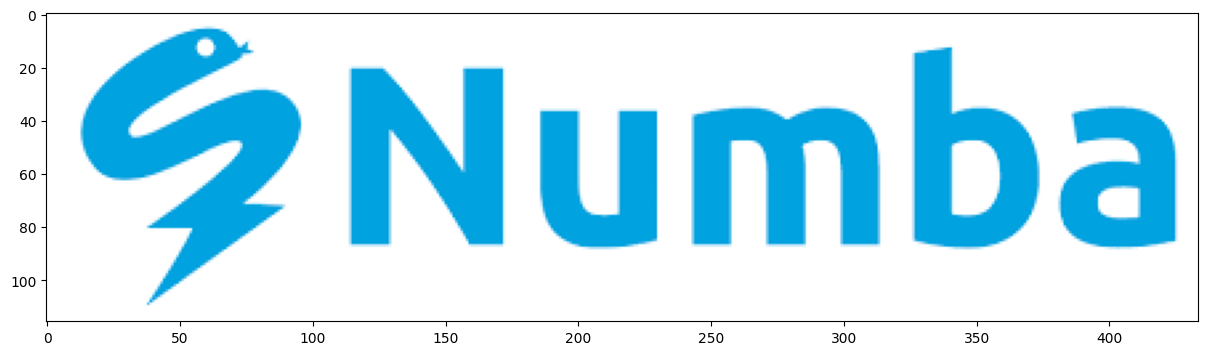

In [4]:
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/main/gpu-python-tutorial/images/numba.png
im = plt.imread("numba.png")
plt.imshow(im)

**2. Move our image to the GPU and create an output array of the same size.**

In [5]:
gpu_im = cuda.to_device(im)
gpu_output = cuda.to_device(np.zeros_like(gpu_im))

**3. Set our two-dimensional thead size and block size.** _Hint: Our `threadsperblock` should still multiply to `128`._

In [6]:
threadsperblock = (8, 16)
blockspergrid_x = (gpu_im.shape[0] // threadsperblock[0]) + 1
blockspergrid_y = (gpu_im.shape[1] // threadsperblock[1]) + 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

**4. Write our kernel.**

In [7]:
@cuda.jit
def black_white(im, output):
    # With our two-dimensional grid we can get our index position in two dimensions
    x, y = cuda.grid(2)

    # Because our grid is slightly larger than our image anything outside the image should be ignored
    if x < im.shape[0] and y < im.shape[1]:

        # Calculate the average across the RGB channels
        avg = (im[x, y, 0] + im[x, y, 1] + im[x, y, 2]) / 3

        # Set all output RGB channels to the average
        output[x, y, 0] = avg
        output[x, y, 1] = avg
        output[x, y, 2] = avg

        # Pass the alpha channel through
        output[x, y, 3] = im[x, y, 3]

**5. Run the kernel.**

In [8]:
black_white[blockspergrid, threadsperblock](gpu_im, gpu_output)

**6. Move the data back from the GPU and plot it.**

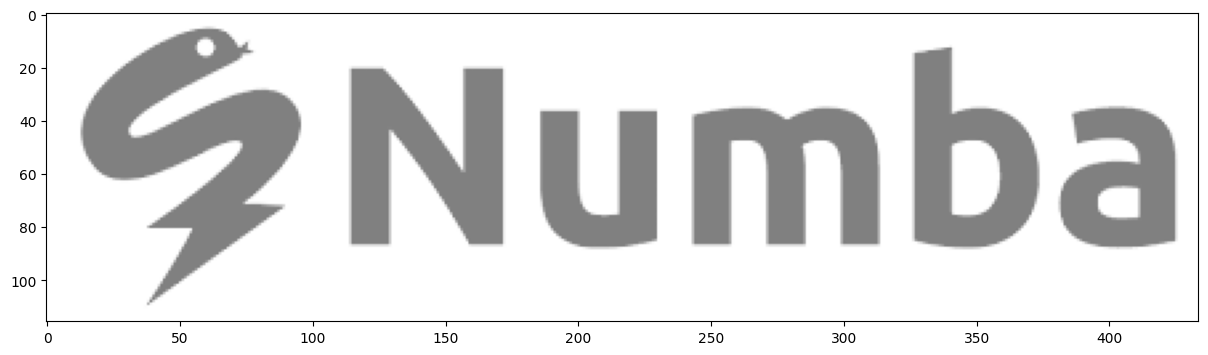

In [9]:
plt.imshow(gpu_output.copy_to_host())